In [1]:
import requests
import pandas as pd
import numpy as np
import folium
from folium import plugins
import os
from datetime import timedelta
import warnings
warnings.filterwarnings("ignore")

# Pull Live data from USGS

In [2]:
# Define the output file path
output_path = r"C:\Users\thoma\Documents\GitHub\USGS\earthquake_data.csv"

# USGS API URL and parameters
url = "https://earthquake.usgs.gov/fdsnws/event/1/query"
min_magnitude = 3.5

# Define the starting and ending year
start_year = 2024
end_year = 2025

# Create an empty list to store data from all years
all_data = []
all_geometries = []  # New list to store geometries

# Loop through each year to pull the data
for year in range(start_year, end_year):
    start_time = f"{year}-01-01"
    end_time = f"{year}-12-31"
    
    params = {
        "format": "geojson",
        "starttime": start_time,
        "endtime": end_time,
        "minmagnitude": min_magnitude,
    }
    
    # Make the request to USGS
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()
        features = data.get('features', [])
        
        # Extract both properties and geometry
        for feature in features:
            properties = feature['properties']
            geometry = feature['geometry']
            
            # Add coordinates to properties
            properties['latitude'] = geometry['coordinates'][1]
            properties['longitude'] = geometry['coordinates'][0]
            properties['depth'] = geometry['coordinates'][2]
            
            all_data.append(properties)
        print(f"Successfully retrieved data for {start_time} to {end_time}")
    else:
        print(f"Failed to retrieve data for {start_time} to {end_time} (Status Code: {response.status_code})")

# Create DataFrame and perform cleaning
df = pd.DataFrame(all_data)

# Convert timestamps to datetime
df['datetime'] = pd.to_datetime(df['time'], unit='ms')

# Clean location data
df[['distance_km', 'location']] = df['place'].str.extract(r'(\d+)\s*km\s+(.+)')
df.loc[~df['distance_km'].notna(), 'location'] = df.loc[~df['distance_km'].notna(), 'place']
df['distance_km'] = pd.to_numeric(df['distance_km'], errors='coerce')

# Handle missing values
numeric_cols = ['felt', 'cdi', 'mmi', 'nst', 'dmin', 'rms', 'gap']
df[numeric_cols] = df[numeric_cols].fillna(-1)

# Drop redundant columns and rename for clarity
columns_to_drop = ['time', 'updated', 'tz', 'url', 'detail', 'ids', 'sources', 'types']
df_clean = df.drop(columns=columns_to_drop)

# Rename columns for clarity
column_renames = {
    'mag': 'magnitude',
    'cdi': 'community_intensity',
    'mmi': 'modified_mercalli_intensity',
    'sig': 'significance',
    'nst': 'num_stations',
    'dmin': 'min_distance',
    'rms': 'root_mean_square',
    'magType': 'magnitude_type'
}
df_clean = df_clean.rename(columns=column_renames)

# Reorder columns for better organization
first_cols = ['datetime', 'magnitude', 'location', 'distance_km', 'latitude', 'longitude', 'depth']
other_cols = [col for col in df_clean.columns if col not in first_cols]
df_clean = df_clean[first_cols + other_cols]

# Save the cleaned dataset
cleaned_output_path = r"C:\Users\thoma\Documents\GitHub\USGS\earthquake_data_cleaned.csv"
df_clean.to_csv(cleaned_output_path, index=False)

# Display information about the cleaned dataset
print("\nCleaned dataset info:")
df_clean.info()

Successfully retrieved data for 2024-01-01 to 2024-12-31

Cleaned dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15483 entries, 0 to 15482
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   datetime                     15483 non-null  datetime64[ns]
 1   magnitude                    15483 non-null  float64       
 2   location                     15483 non-null  object        
 3   distance_km                  11906 non-null  float64       
 4   latitude                     15483 non-null  float64       
 5   longitude                    15483 non-null  float64       
 6   depth                        15483 non-null  float64       
 7   place                        15483 non-null  object        
 8   felt                         15483 non-null  float64       
 9   community_intensity          15483 non-null  float64       
 10  modified_mercalli_intensit

# Visualize Historical Earthquaks on a Map

In [3]:
# Read the data
df = pd.read_csv(r"C:\Users\thoma\Documents\GitHub\USGS\earthquake_data_cleaned.csv")

# Filter for major earthquakes (magnitude >= 6.0)
major_quakes = df[df['magnitude'] >= 6.0].copy()

# Create base map with a darker style
center_lat = major_quakes['latitude'].median()
center_lon = major_quakes['longitude'].median()
m = folium.Map(location=[center_lat, center_lon], zoom_start=3, 
               tiles='CartoDB dark_matter')

# Add marker cluster
marker_cluster = plugins.MarkerCluster().add_to(m)

# Create a colormap for magnitude
def get_magnitude_color(magnitude):
    if magnitude >= 8.0:
        return '#FF1E1E'  # Bright red
    elif magnitude >= 7.0:
        return '#FF9000'  # Bright orange
    else:
        return '#FFD700'  # Gold

# Add earthquake points to cluster
for idx, row in major_quakes.iterrows():
    # Create popup text
    popup_text = f"""
    <div style="font-family: Arial; width: 200px;">
        <h4 style="margin: 0; color: {'#FF1E1E' if row['magnitude'] >= 8.0 else '#FF9000' if row['magnitude'] >= 7.0 else '#FFD700'}">
            Magnitude {row['magnitude']:.1f}
        </h4>
        <hr style="margin: 4px 0;">
        <b>Date:</b> {row['datetime']}<br>
        <b>Depth:</b> {row['depth']:.1f} km<br>
        <b>Location:</b> {str(row['location'])}
    </div>
    """
    
    # Add circle marker
    folium.CircleMarker(
        location=[float(row['latitude']), float(row['longitude'])],
        radius=float(row['magnitude']) * 1.5,
        popup=folium.Popup(popup_text, max_width=300),
        color=get_magnitude_color(row['magnitude']),
        fill=True,
        fillOpacity=0.7,
        weight=2
    ).add_to(marker_cluster)

# Add heatmap layer
heat_data = [[row['latitude'], row['longitude']] for idx, row in major_quakes.iterrows()]
plugins.HeatMap(
    heat_data,
    min_opacity=0.2,
    radius=25,
    blur=15,
    max_zoom=1,
).add_to(m)

# Add layer control
folium.LayerControl().add_to(m)

# Add a more stylish legend
legend_html = '''
<div style="position: fixed; 
            bottom: 50px; right: 50px; width: 200px;
            border:2px solid rgba(255, 255, 255, 0.2);
            border-radius: 10px;
            z-index:9999; 
            background-color:rgba(0, 0, 0, 0.7);
            color: white;
            padding: 15px;
            font-family: Arial;">
            <h4 style="margin: 0 0 10px 0;">Major Earthquakes</h4>
            <div style="margin: 5px 0;">
                <i class="fa fa-circle fa-1x" style="color:#FF1E1E"></i> Magnitude ≥ 8.0
            </div>
            <div style="margin: 5px 0;">
                <i class="fa fa-circle fa-1x" style="color:#FF9000"></i> Magnitude 7.0 - 7.9
            </div>
            <div style="margin: 5px 0;">
                <i class="fa fa-circle fa-1x" style="color:#FFD700"></i> Magnitude 6.0 - 6.9
            </div>
</div>
'''
m.get_root().html.add_child(folium.Element(legend_html))

# Save the map
map_path = r"C:\Users\thoma\Documents\GitHub\USGS\major_earthquakes_styled.html"
m.save(map_path)

# Print statistics
print("\nMajor Earthquakes Statistics (Magnitude ≥ 6.0):")
print(f"Total number of major earthquakes: {len(major_quakes)}")
print("\nBreakdown by magnitude range:")
print(f"8.0 or higher: {len(major_quakes[major_quakes['magnitude'] >= 8.0])}")
print(f"7.0 to 7.9: {len(major_quakes[(major_quakes['magnitude'] >= 7.0) & (major_quakes['magnitude'] < 8.0)])}")
print(f"6.0 to 6.9: {len(major_quakes[(major_quakes['magnitude'] >= 6.0) & (major_quakes['magnitude'] < 7.0)])}")
print(f"\nMap saved to: {map_path}")


Major Earthquakes Statistics (Magnitude ≥ 6.0):
Total number of major earthquakes: 99

Breakdown by magnitude range:
8.0 or higher: 0
7.0 to 7.9: 10
6.0 to 6.9: 89

Map saved to: C:\Users\thoma\Documents\GitHub\USGS\major_earthquakes_styled.html


# Engineer Target

In [4]:
import pandas as pd
import numpy as np
from datetime import timedelta
from tqdm import tqdm
from math import radians, sin, cos, sqrt, asin

def haversine_distance(lat1, lon1, lat2, lon2):
    """Calculate distance between two points on Earth using Haversine formula."""
    R = 6371  # Earth's radius in kilometers
    
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    return R * c

# Convert datetime to pandas datetime if not already done
df['datetime'] = pd.to_datetime(df['datetime'])

# Sort by datetime
df = df.sort_values('datetime').reset_index(drop=True)

# First, find all M6.0+ earthquakes
large_earthquakes = df[df['magnitude'] >= 6.0][['datetime', 'latitude', 'longitude', 'magnitude']]
print(f"Number of M6.0+ earthquakes: {len(large_earthquakes)}")

# Initialize target column
df['large_eq_next_30d_100km'] = 0

# Parameters
TIME_WINDOW = 30  # days
DISTANCE_THRESHOLD = 100  # kilometers

# Create target column
print("\nCreating target column (this may take a few minutes)...")
for i in tqdm(range(len(df)-1)):  # -1 because we can't predict beyond our last data point
    current_date = df.loc[i, 'datetime']
    future_date = current_date + timedelta(days=TIME_WINDOW)
    current_lat = df.loc[i, 'latitude']
    current_lon = df.loc[i, 'longitude']
    
    # Get future large earthquakes within the time window
    future_large = large_earthquakes[
        (large_earthquakes['datetime'] > current_date) & 
        (large_earthquakes['datetime'] <= future_date)
    ]
    
    # If there are any temporally valid large earthquakes, check their distances
    if len(future_large) > 0:
        for _, large_eq in future_large.iterrows():
            distance = haversine_distance(
                current_lat, current_lon,
                large_eq['latitude'], large_eq['longitude']
            )
            if distance <= DISTANCE_THRESHOLD:
                df.loc[i, 'large_eq_next_30d_100km'] = 1
                break

# Display statistics
total_samples = len(df)
positive_samples = df['large_eq_next_30d_100km'].sum()
print("\nTarget Variable Statistics:")
print(f"Total samples: {total_samples:,}")
print(f"Samples with M6.0+ earthquake within next {TIME_WINDOW} days and {DISTANCE_THRESHOLD}km: {positive_samples:,}")
print(f"Percentage of positive samples: {(positive_samples/total_samples)*100:.2f}%")

# Verify some examples
print("\nVerifying some examples:")
for i in range(5):
    idx = df[df['large_eq_next_30d_100km'] == 1].index[i]
    row = df.loc[idx]
    current_date = row['datetime']
    future_date = current_date + timedelta(days=TIME_WINDOW)
    
    # Find the next large earthquake within distance threshold
    future_large = large_earthquakes[
        (large_earthquakes['datetime'] > current_date) & 
        (large_earthquakes['datetime'] <= future_date)
    ]
    
    closest_eq = None
    min_distance = float('inf')
    
    for _, large_eq in future_large.iterrows():
        distance = haversine_distance(
            row['latitude'], row['longitude'],
            large_eq['latitude'], large_eq['longitude']
        )
        if distance <= DISTANCE_THRESHOLD and distance < min_distance:
            closest_eq = large_eq
            min_distance = distance
    
    print(f"\nExample {i+1}:")
    print(f"Current earthquake: {current_date}, M{row['magnitude']:.1f}")
    print(f"Location: ({row['latitude']:.2f}, {row['longitude']:.2f})")
    print(f"Next large earthquake: {closest_eq['datetime']}, M{closest_eq['magnitude']:.1f}")
    print(f"Location: ({closest_eq['latitude']:.2f}, {closest_eq['longitude']:.2f})")
    print(f"Distance: {min_distance:.1f} km")
    print(f"Days until: {(closest_eq['datetime'] - current_date).days}")

# Save the dataset
output_path = r"C:\Users\thoma\Documents\GitHub\USGS\earthquake_data_with_spatiotemporal_target.csv"
df.to_csv(output_path, index=False)
df.to_csv(output_path, index=False)

Number of M6.0+ earthquakes: 99

Creating target column (this may take a few minutes)...


100%|██████████| 15482/15482 [00:14<00:00, 1069.15it/s]



Target Variable Statistics:
Total samples: 15,483
Samples with M6.0+ earthquake within next 30 days and 100km: 630
Percentage of positive samples: 4.07%

Verifying some examples:

Example 1:
Current earthquake: 2024-01-01 00:37:09.096000, M4.7
Location: (17.66, 145.46)
Next large earthquake: 2024-01-20 15:48:40.121000, M6.1
Location: (18.52, 145.63)
Distance: 97.0 km
Days until: 19

Example 2:
Current earthquake: 2024-01-01 07:06:05.477000, M5.8
Location: (37.49, 137.25)
Next large earthquake: 2024-01-01 07:10:09.476000, M7.5
Location: (37.49, 137.27)
Distance: 2.0 km
Days until: 0

Example 3:
Current earthquake: 2024-01-01 07:10:09.476000, M7.5
Location: (37.49, 137.27)
Next large earthquake: 2024-01-01 07:18:41.584000, M6.2
Location: (37.19, 136.83)
Distance: 51.3 km
Days until: 0

Example 4:
Current earthquake: 2024-01-01 21:34:19.009000, M4.1
Location: (19.18, 145.38)
Next large earthquake: 2024-01-20 15:48:40.121000, M6.1
Location: (18.52, 145.63)
Distance: 77.7 km
Days until: 18

In [5]:
# Old target


# Test Features and EDA beore engineering

In [7]:
# Sort by datetime
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')

df = df.sort_values('datetime').reset_index(drop=True)

# Create basic time features
print("Creating basic time features...")
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['day_of_week'] = df['datetime'].dt.dayofweek
df['day_of_year'] = df['datetime'].dt.dayofyear

Creating basic time features...


# 

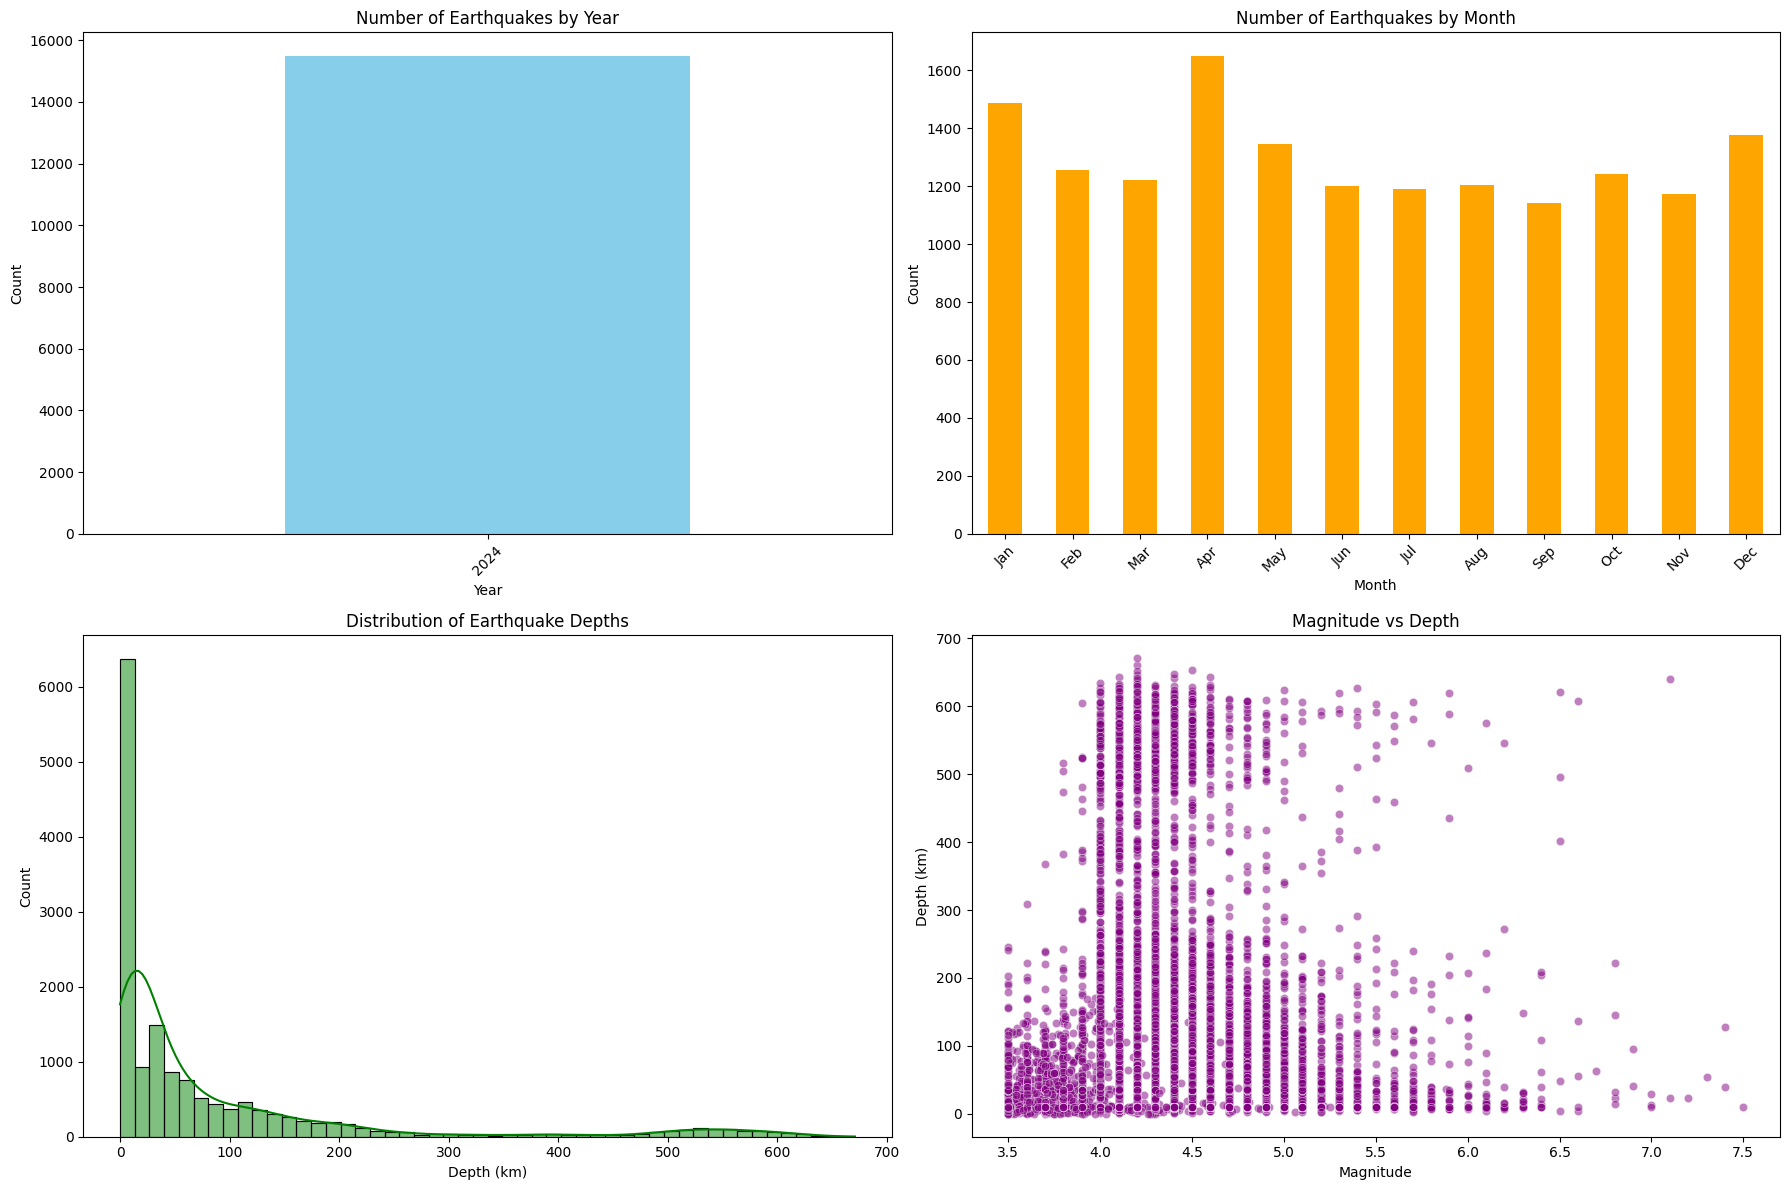

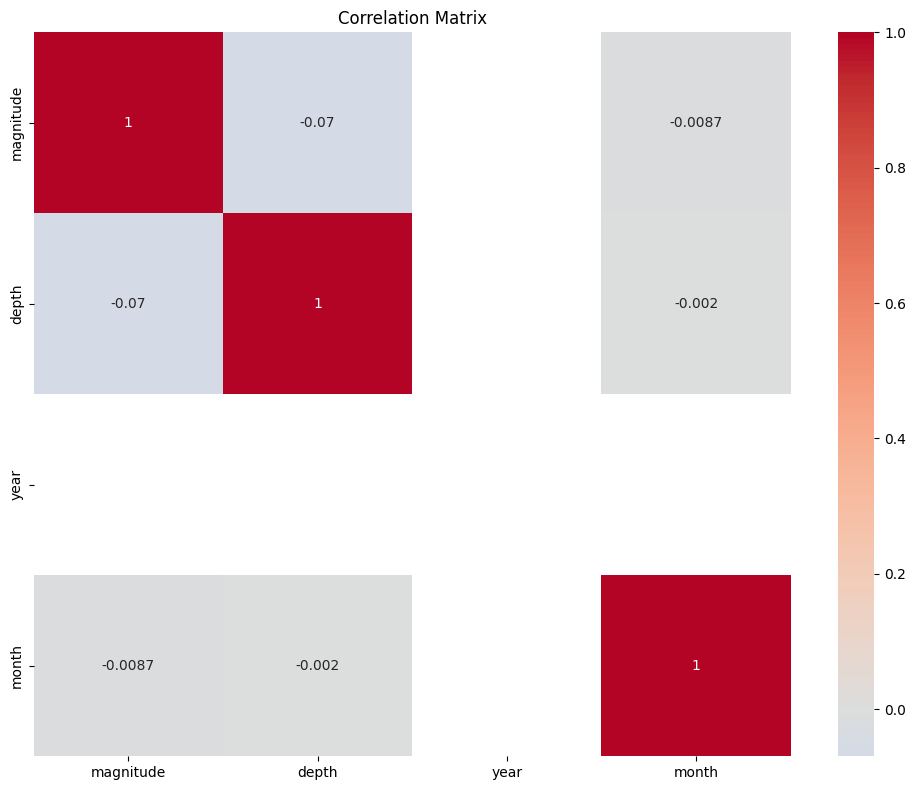

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.cluster import DBSCAN
from datetime import datetime

# 1. Temporal Analysis: Annual and Monthly Trends
plt.figure(figsize=(18, 12))  # Create a larger grid for all subplots

# Subplot 1: Annual Trends
plt.subplot(2, 2, 1)
annual_counts = df.groupby('year').size()
annual_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Earthquakes by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Subplot 2: Monthly Trends
plt.subplot(2, 2, 2)
monthly_counts = df.groupby('month').size()
monthly_counts.plot(kind='bar', color='orange')
plt.title('Number of Earthquakes by Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], 
           rotation=45)

# 2. Depth Analysis
# Subplot 3: Depth Distribution
plt.subplot(2, 2, 3)
sns.histplot(data=df, x='depth', bins=50, color='green', kde=True)
plt.title('Distribution of Earthquake Depths')
plt.xlabel('Depth (km)')
plt.ylabel('Count')

# Subplot 4: Magnitude vs Depth Scatterplot
plt.subplot(2, 2, 4)
sns.scatterplot(data=df, x='magnitude', y='depth', alpha=0.5, color='purple')
plt.title('Magnitude vs Depth')
plt.xlabel('Magnitude')
plt.ylabel('Depth (km)')

# Adjust layout for all subplots
plt.tight_layout()
plt.show()

# 3. Correlation Analysis: Heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = df[['magnitude', 'depth', 'year', 'month']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

Selected features: 20
First few features: ['magnitude', 'distance_km', 'latitude', 'longitude', 'depth']
Training Random Forest...


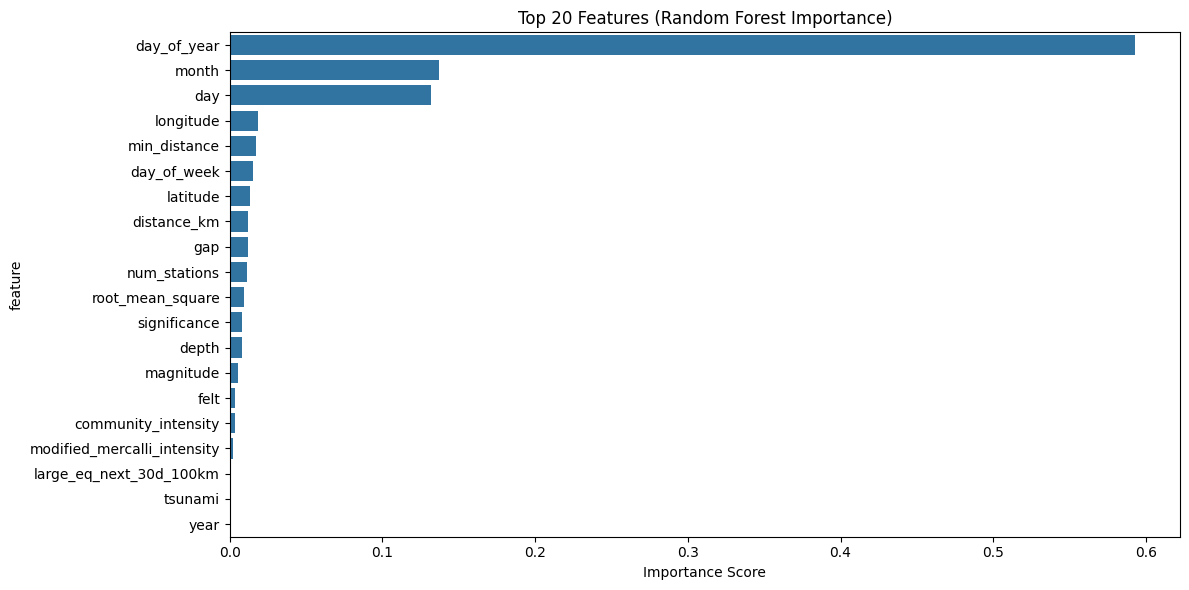


Training XGBoost...


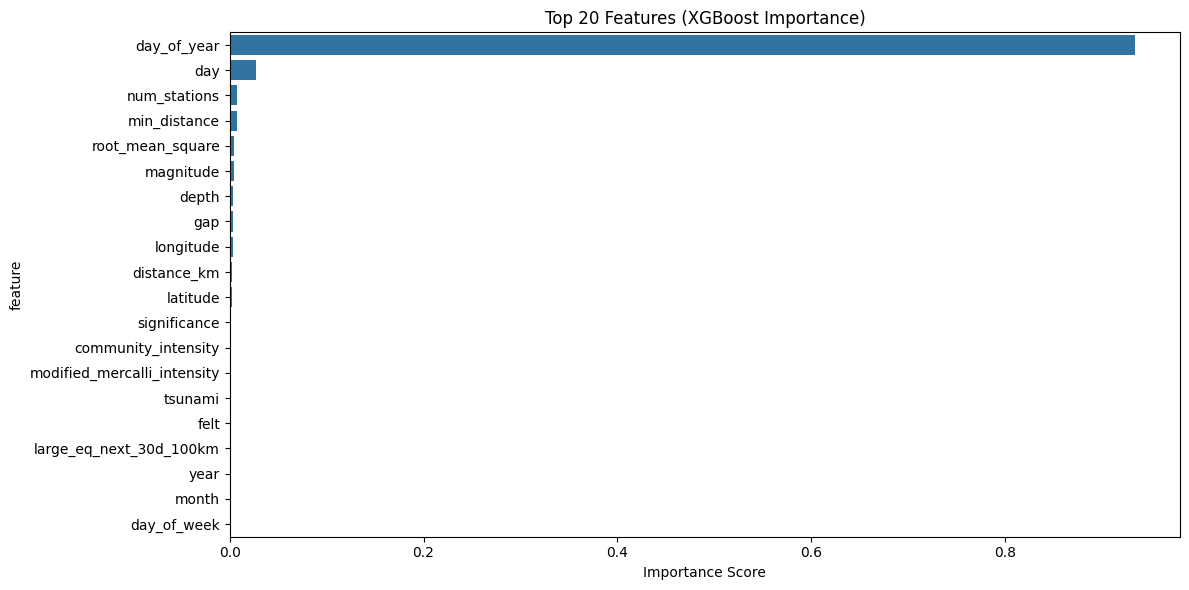


Calculating SHAP values...


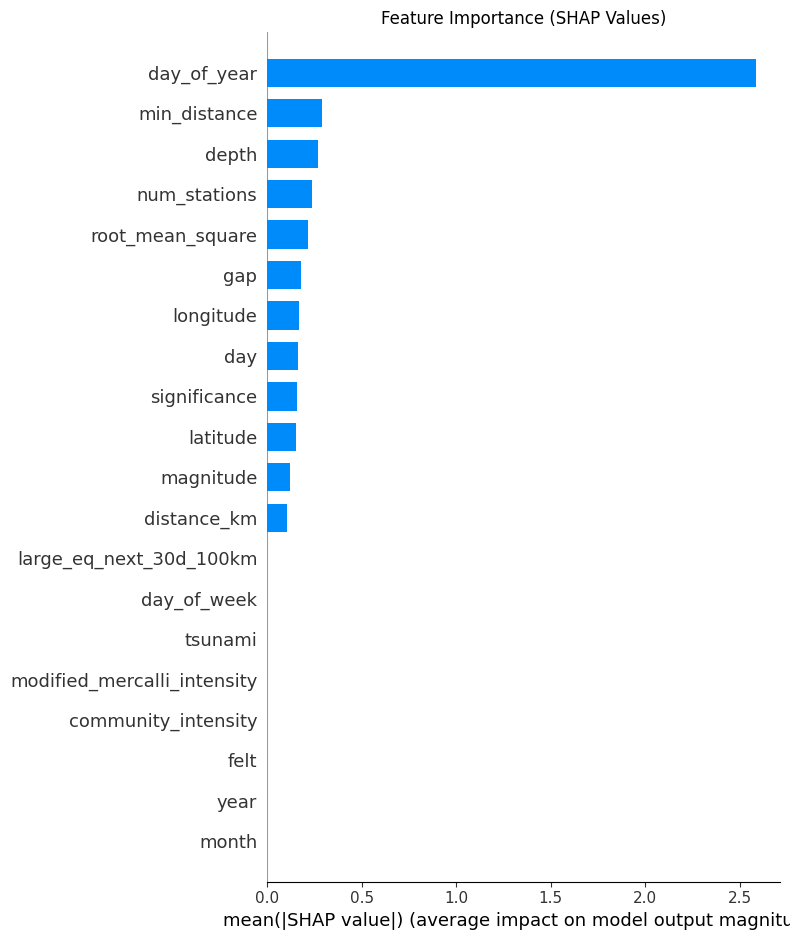


Feature Importance Summary:

Top 20 Most Important Features (Average across all methods):
                        feature  rf_importance  xgb_importance  \
19                  day_of_year       0.592707        0.934000   
17                          day       0.132082        0.026586   
16                        month       0.137126        0.000000   
11                 min_distance       0.016862        0.007471   
10                 num_stations       0.011176        0.007793   
4                         depth       0.007689        0.003561   
12             root_mean_square       0.009336        0.004565   
3                     longitude       0.018449        0.002971   
13                          gap       0.011872        0.003316   
2                      latitude       0.013418        0.001881   
9                  significance       0.008028        0.001286   
1                   distance_km       0.011874        0.002117   
0                     magnitude       0.005633     

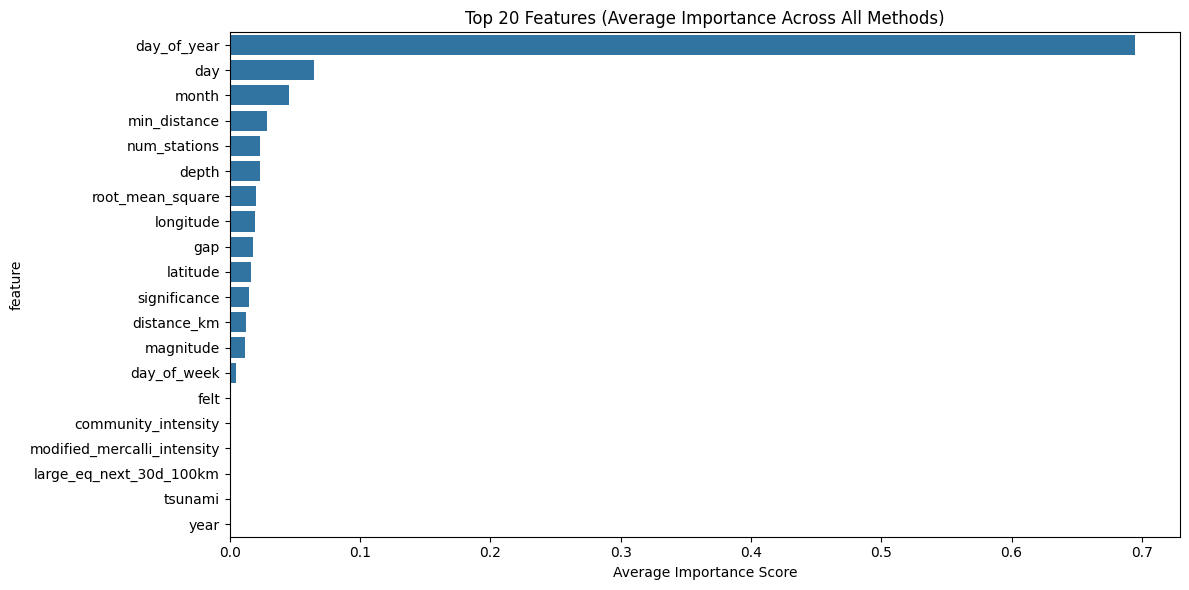


Random Forest Performance:
              precision    recall  f1-score   support

           0       0.96      0.77      0.86        31
           1       1.00      1.00      1.00      3066

    accuracy                           1.00      3097
   macro avg       0.98      0.89      0.93      3097
weighted avg       1.00      1.00      1.00      3097


XGBoost Performance:
              precision    recall  f1-score   support

           0       0.89      0.81      0.85        31
           1       1.00      1.00      1.00      3066

    accuracy                           1.00      3097
   macro avg       0.95      0.90      0.92      3097
weighted avg       1.00      1.00      1.00      3097



In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import shap
from sklearn.preprocessing import StandardScaler

# Prepare features and target
# Exclude non-feature columns and string columns
exclude_cols = ['datetime', 'location', 'large_eq_next_30d', 'place', 'title', 'magType', 'net', 'code', 'ids', 'sources', 'types', 'status', 'alert']

# Get numeric columns only
numeric_cols = df.select_dtypes(include=[np.number]).columns
feature_cols = [col for col in numeric_cols if col not in exclude_cols]

print("Selected features:", len(feature_cols))
print("First few features:", feature_cols[:5])

X = df[feature_cols]
y = df['large_eq_next_30d']

# Check for any remaining non-numeric values or infinities
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.mean())

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to DataFrame to maintain feature names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_cols)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_cols)

# 1. Random Forest Importance
print("Training Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Get feature importance
rf_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
})
rf_importance = rf_importance.sort_values('importance', ascending=False)

# Plot RF importance
plt.figure(figsize=(12, 6))
sns.barplot(data=rf_importance.head(20), x='importance', y='feature')
plt.title('Top 20 Features (Random Forest Importance)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

# 2. XGBoost Importance
print("\nTraining XGBoost...")
xgb_model = XGBClassifier(n_estimators=100, random_state=42)
xgb_model.fit(X_train_scaled, y_train)

# Get feature importance
xgb_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': xgb_model.feature_importances_
})
xgb_importance = xgb_importance.sort_values('importance', ascending=False)

# Plot XGBoost importance
plt.figure(figsize=(12, 6))
sns.barplot(data=xgb_importance.head(20), x='importance', y='feature')
plt.title('Top 20 Features (XGBoost Importance)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

# 3. SHAP Values
print("\nCalculating SHAP values...")
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_scaled)

# Plot SHAP summary
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_scaled, plot_type="bar", show=False)
plt.title('Feature Importance (SHAP Values)')
plt.tight_layout()
plt.show()

# Create detailed feature importance summary
print("\nFeature Importance Summary:")
importance_summary = pd.DataFrame({
    'feature': feature_cols,
    'rf_importance': rf_model.feature_importances_,
    'xgb_importance': xgb_model.feature_importances_,
    'shap_importance': np.abs(shap_values).mean(0)
})

# Normalize importance scores
for col in ['rf_importance', 'xgb_importance', 'shap_importance']:
    importance_summary[col] = importance_summary[col] / importance_summary[col].sum()

# Calculate average importance
importance_summary['avg_importance'] = importance_summary[['rf_importance', 'xgb_importance', 'shap_importance']].mean(axis=1)
importance_summary = importance_summary.sort_values('avg_importance', ascending=False)

# Print top 20 most important features
print("\nTop 20 Most Important Features (Average across all methods):")
print(importance_summary.head(20))

# Save feature importance results
output_path = r"C:\Users\thoma\Documents\GitHub\USGS\feature_importance_results.csv"
importance_summary.to_csv(output_path, index=False)
print(f"\nFeature importance results saved to: {output_path}")

# Plot average importance
plt.figure(figsize=(12, 6))
sns.barplot(data=importance_summary.head(20), x='avg_importance', y='feature')
plt.title('Top 20 Features (Average Importance Across All Methods)')
plt.xlabel('Average Importance Score')
plt.tight_layout()
plt.show()

# Print model performance metrics
from sklearn.metrics import classification_report, confusion_matrix
print("\nRandom Forest Performance:")
print(classification_report(y_test, rf_model.predict(X_test_scaled)))

print("\nXGBoost Performance:")
print(classification_report(y_test, xgb_model.predict(X_test_scaled)))

# Data Cleansing 

In [10]:
from scipy.spatial.distance import cdist
from tqdm import tqdm

# Data preparation
print("Preparing data...")
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')

# Remove any rows with invalid datetime
df = df.dropna(subset=['datetime'])

# Sort by datetime
df = df.sort_values('datetime').reset_index(drop=True)

# Create basic time features
print("Creating basic time features...")
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['day_of_week'] = df['datetime'].dt.dayofweek
df['day_of_year'] = df['datetime'].dt.dayofyear

# Validate numeric columns
print("Validating numeric columns...")
df['magnitude'] = pd.to_numeric(df['magnitude'], errors='coerce')
df['depth'] = pd.to_numeric(df['depth'], errors='coerce')
df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')
df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')

# Fill NaN values with appropriate methods
df['magnitude'] = df['magnitude'].fillna(df['magnitude'].mean())
df['depth'] = df['depth'].fillna(df['depth'].mean())
df['latitude'] = df['latitude'].fillna(df['latitude'].mean())
df['longitude'] = df['longitude'].fillna(df['longitude'].mean())



Preparing data...
Creating basic time features...
Validating numeric columns...


# Engineer Features

In [11]:
# Create rolling window features (7, 14, and 30 days)
print("Creating rolling window features...")
windows = [7, 14, 30]

# Group by date first to handle multiple earthquakes per day
daily_stats = df.groupby(df['datetime'].dt.date).agg({
    'magnitude': ['count', 'mean', 'max', 'std'],
    'depth': ['mean', 'max', 'std']
}).reset_index()

# Rename columns
daily_stats.columns = ['date', 'eq_count', 'mag_mean', 'mag_max', 'mag_std', 
                      'depth_mean', 'depth_max', 'depth_std']
daily_stats['date'] = pd.to_datetime(daily_stats['date'])

# Create rolling features
for window in windows:
    # Create rolling statistics
    rolling_stats = daily_stats.set_index('date').rolling(window=window, min_periods=1).agg({
        'eq_count': 'sum',
        'mag_mean': 'mean',
        'mag_max': 'max',
        'mag_std': 'mean',
        'depth_mean': 'mean',
        'depth_max': 'max',
        'depth_std': 'mean'
    }).reset_index()
    
    # Rename columns
    rolling_stats.columns = ['date'] + [
        f'{col}_{window}d' for col in ['eq_count', 'mag_mean', 'mag_max', 'mag_std',
                                      'depth_mean', 'depth_max', 'depth_std']
    ]
    
    # Merge back to original dataframe
    df = pd.merge_asof(
        df,
        rolling_stats,
        left_on='datetime',
        right_on='date',
        direction='backward'
    )
    
    # Drop the temporary date column
    df = df.drop('date', axis=1)

# Create features for recent large earthquakes
print("Creating large earthquake features...")
magnitude_thresholds = [5.0, 5.5, 6.0]

for mag in magnitude_thresholds:
    # Calculate days since last major earthquake
    df[f'days_since_mag{mag}'] = df['datetime'].diff().dt.total_seconds() / (24 * 60 * 60)
    major_eq_mask = df['magnitude'] >= mag
    df.loc[major_eq_mask, f'days_since_mag{mag}'] = 0
    df[f'days_since_mag{mag}'] = df[f'days_since_mag{mag}'].fillna(method='ffill').fillna(0)
    
    # Count major earthquakes in different windows
    for window in windows:
        window_start = df['datetime'] - pd.Timedelta(days=window)
        df[f'eq_count_mag{mag}_{window}d'] = df.apply(
            lambda row: len(df[
                (df['datetime'] >= window_start[row.name]) & 
                (df['datetime'] < row['datetime']) & 
                (df['magnitude'] >= mag)
            ]),
            axis=1
        )

# Create geographic density features
print("Creating geographic density features...")
radii = [100, 300, 500]  # kilometers

def count_nearby_earthquakes(row, data, km_radius):
    # Convert degrees to approximate kilometers (simplified calculation)
    lat_km = 111  # 1 degree latitude ≈ 111 km
    lon_km = 111 * np.cos(np.radians(row['latitude']))  # longitude degrees to km conversion varies with latitude
    
    # Calculate boundaries (faster than calculating individual distances)
    lat_radius = km_radius / lat_km
    lon_radius = km_radius / lon_km
    
    nearby = data[
        (data['latitude'].between(row['latitude'] - lat_radius, row['latitude'] + lat_radius)) &
        (data['longitude'].between(row['longitude'] - lon_radius, row['longitude'] + lon_radius)) &
        (data['datetime'].between(row['datetime'] - pd.Timedelta(days=30), row['datetime']))
    ]
    
    return len(nearby)

for radius in radii:
    print(f"Processing {radius}km radius...")
    df[f'nearby_eq_{radius}km'] = df.apply(
        lambda row: count_nearby_earthquakes(row, df, radius),
        axis=1
    )

# Fill any missing values
df = df.fillna(0)

# Save the dataset with time series features
print("Saving dataset...")
output_path = r"C:\Users\thoma\Documents\GitHub\USGS\earthquake_data_with_features.csv"
df.to_csv(output_path, index=False)

# Display information about the features
print("\nFeature Creation Complete!")
print(f"Total number of features: {len(df.columns)}")
print("\nSample of new features:")
feature_cols = [col for col in df.columns if any(f'{window}d' in col for window in windows)]
print("\nRolling window features:", feature_cols[:5], "...")
print("\nShape of final dataset:", df.shape)

Creating rolling window features...
Creating large earthquake features...
Creating geographic density features...
Processing 100km radius...
Processing 300km radius...
Processing 500km radius...
Saving dataset...

Feature Creation Complete!
Total number of features: 67

Sample of new features:

Rolling window features: ['large_eq_next_30d_100km', 'large_eq_next_30d', 'eq_count_7d', 'mag_mean_7d', 'mag_max_7d'] ...

Shape of final dataset: (15483, 67)


# Generate SAMIRA Model
##### CPU/GPU paralle processing 

In [12]:
# Pulled for now

#EDA

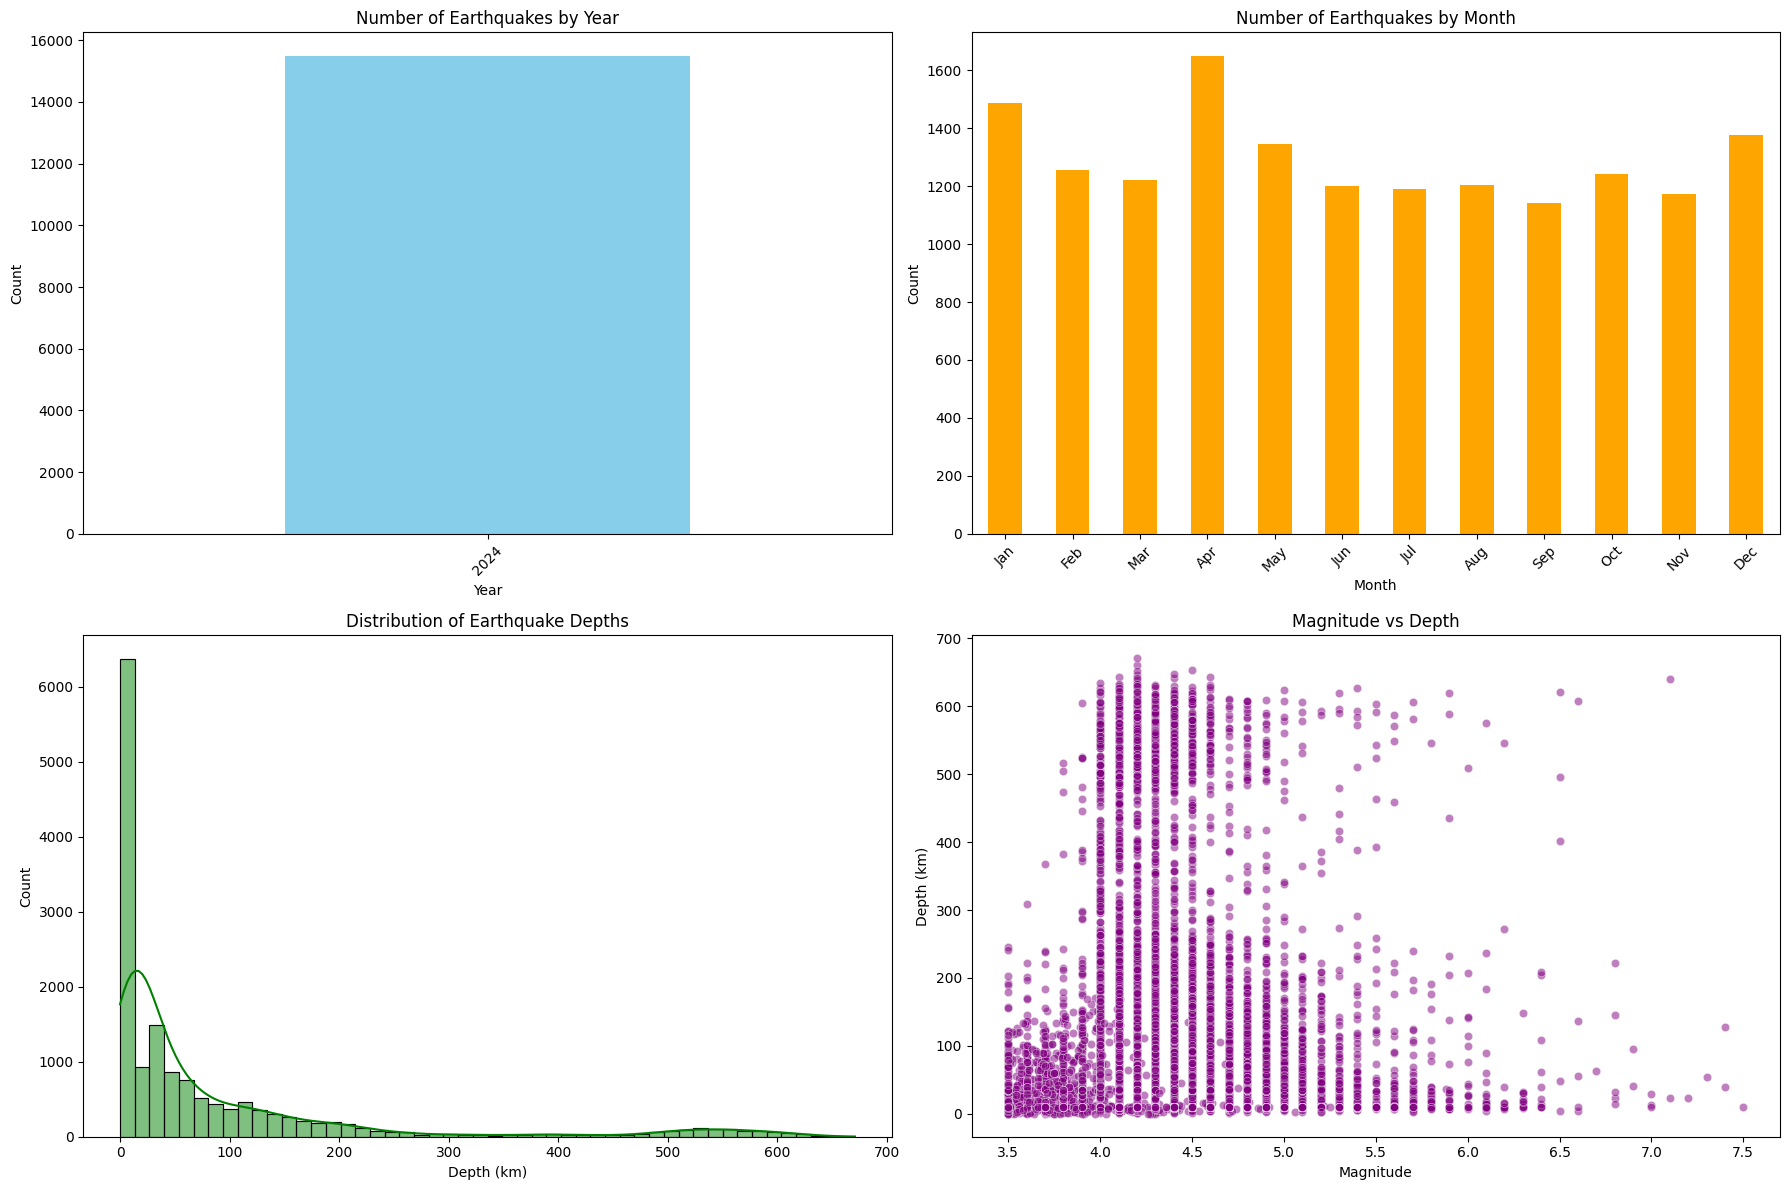

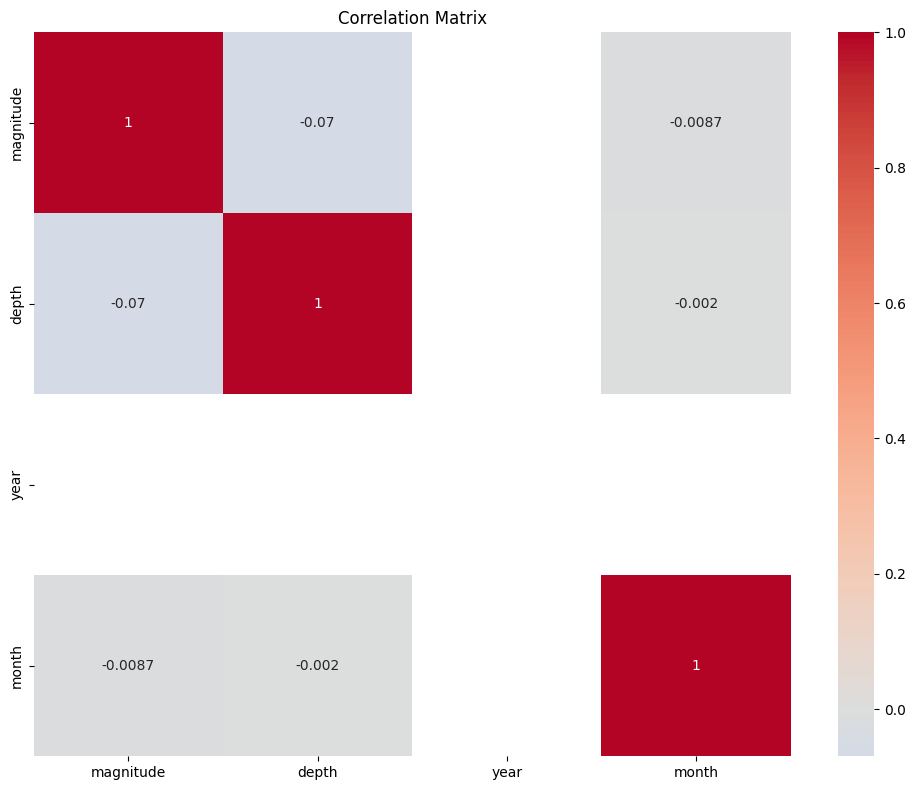

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.cluster import DBSCAN
from datetime import datetime

# 1. Temporal Analysis: Annual and Monthly Trends
plt.figure(figsize=(18, 12))  # Create a larger grid for all subplots

# Subplot 1: Annual Trends
plt.subplot(2, 2, 1)
annual_counts = df.groupby('year').size()
annual_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Earthquakes by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Subplot 2: Monthly Trends
plt.subplot(2, 2, 2)
monthly_counts = df.groupby('month').size()
monthly_counts.plot(kind='bar', color='orange')
plt.title('Number of Earthquakes by Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], 
           rotation=45)

# 2. Depth Analysis
# Subplot 3: Depth Distribution
plt.subplot(2, 2, 3)
sns.histplot(data=df, x='depth', bins=50, color='green', kde=True)
plt.title('Distribution of Earthquake Depths')
plt.xlabel('Depth (km)')
plt.ylabel('Count')

# Subplot 4: Magnitude vs Depth Scatterplot
plt.subplot(2, 2, 4)
sns.scatterplot(data=df, x='magnitude', y='depth', alpha=0.5, color='purple')
plt.title('Magnitude vs Depth')
plt.xlabel('Magnitude')
plt.ylabel('Depth (km)')

# Adjust layout for all subplots
plt.tight_layout()
plt.show()

# 3. Correlation Analysis: Heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = df[['magnitude', 'depth', 'year', 'month']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()


# Feature Importance

In [14]:
#!pip install shap

In [15]:
# Pulled SARIMA Features

Selected features: 56
First few features: ['magnitude', 'distance_km', 'latitude', 'longitude', 'depth']
Training Random Forest...


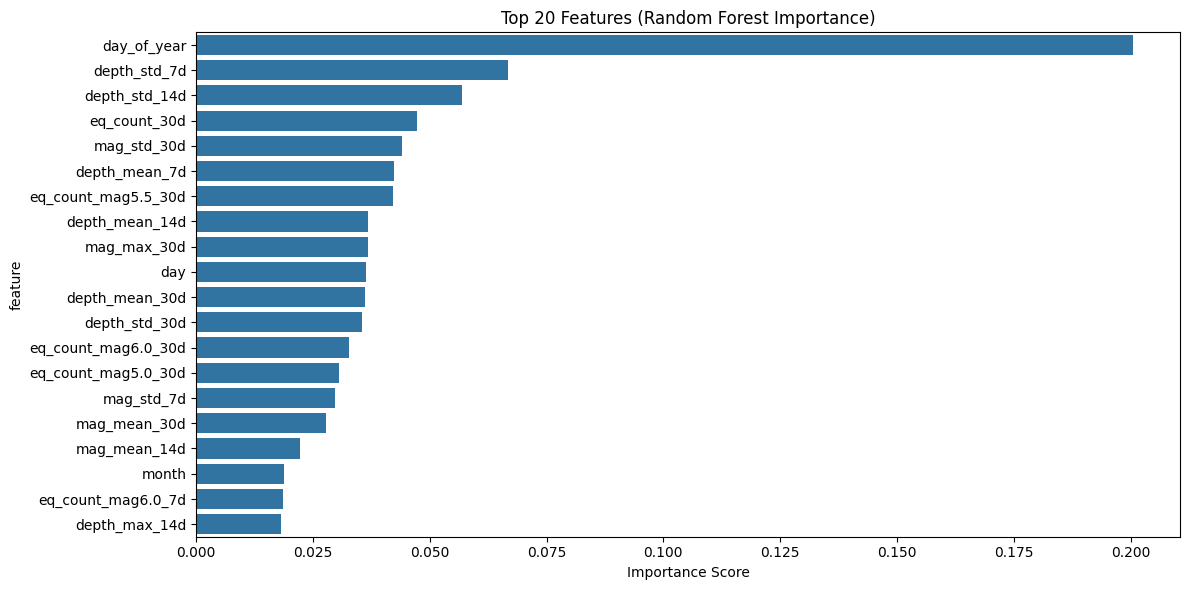


Training XGBoost...


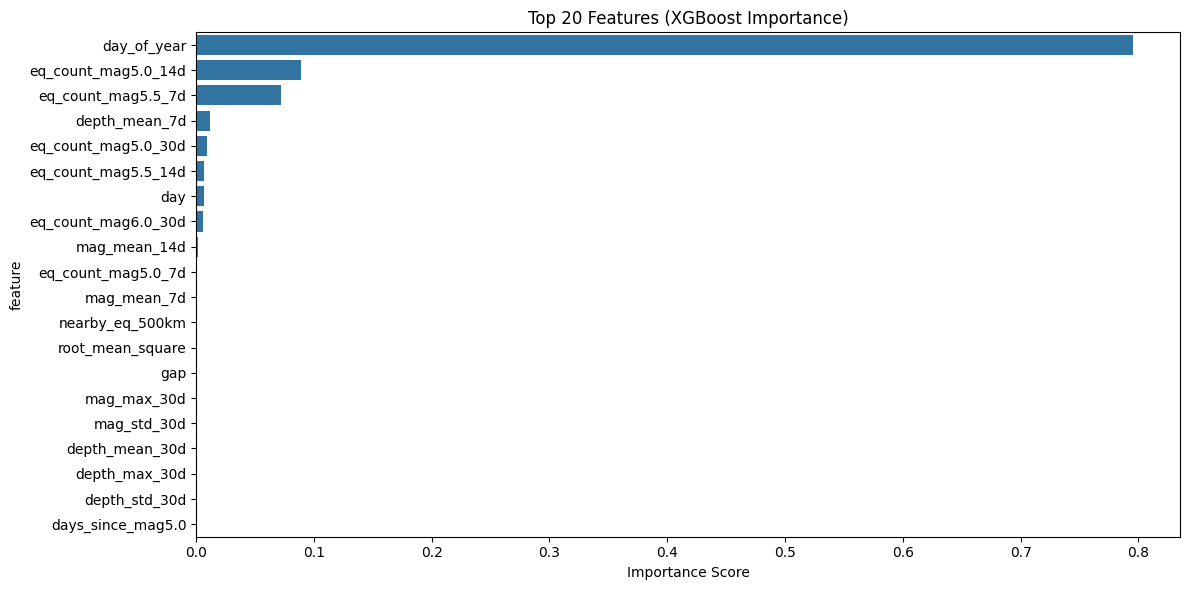


Calculating SHAP values...


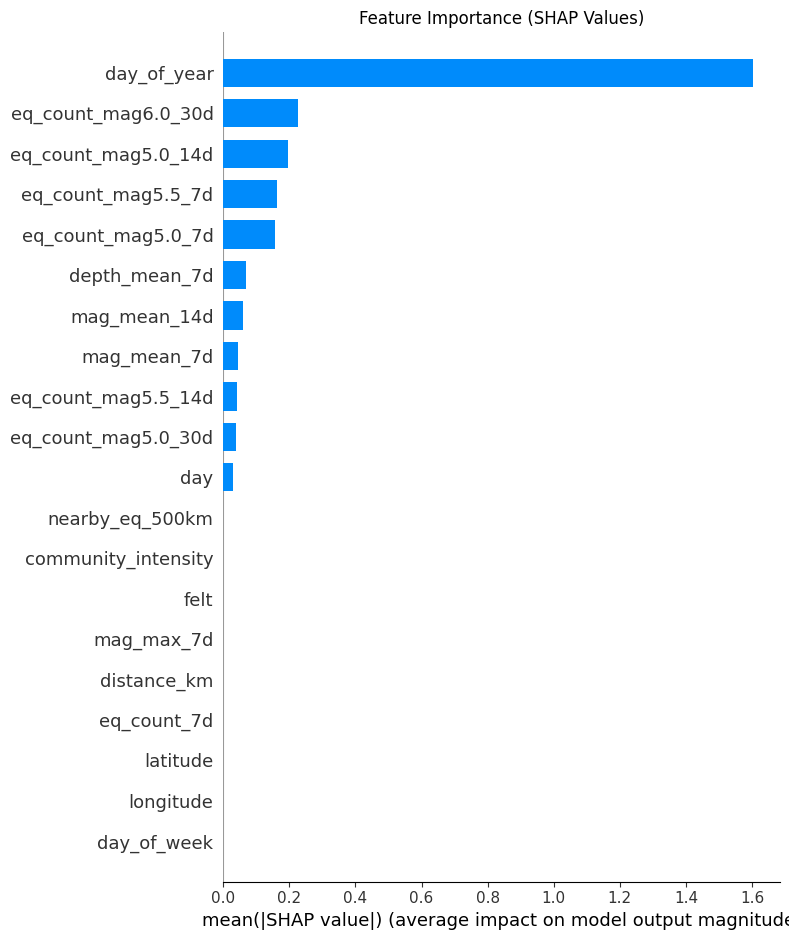


Feature Importance Summary:

Top 20 Most Important Features (Average across all methods):
                feature  rf_importance  xgb_importance  shap_importance  \
19          day_of_year       0.200551        0.795583         0.610378   
43  eq_count_mag5.0_14d       0.013308        0.089059         0.074265   
46   eq_count_mag5.5_7d       0.012584        0.072142         0.062054   
52  eq_count_mag6.0_30d       0.032624        0.005966         0.085838   
24        depth_mean_7d       0.042379        0.011655         0.025802   
42   eq_count_mag5.0_7d       0.015505        0.001119         0.059816   
26         depth_std_7d       0.066824        0.000000         0.000000   
33        depth_std_14d       0.056931        0.000000         0.000000   
17                  day       0.036247        0.006463         0.011225   
44  eq_count_mag5.0_30d       0.030502        0.008821         0.014307   
34         eq_count_30d       0.047266        0.000000         0.000000   
28       

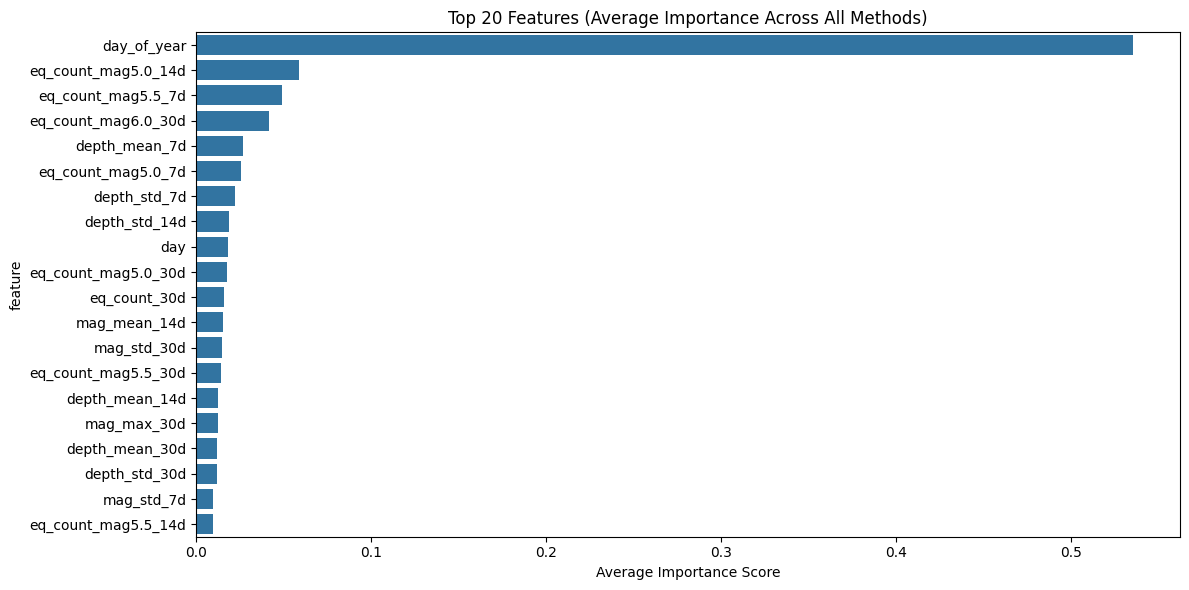


Random Forest Performance:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        31
           1       1.00      1.00      1.00      3066

    accuracy                           1.00      3097
   macro avg       1.00      0.98      0.99      3097
weighted avg       1.00      1.00      1.00      3097


XGBoost Performance:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        31
           1       1.00      1.00      1.00      3066

    accuracy                           1.00      3097
   macro avg       1.00      0.98      0.99      3097
weighted avg       1.00      1.00      1.00      3097



In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import shap
from sklearn.preprocessing import StandardScaler

# Read the data with features
df = pd.read_csv(r"C:\Users\thoma\Documents\GitHub\USGS\earthquake_data_with_features.csv")

# Prepare features and target
# Exclude non-feature columns and string columns
exclude_cols = ['datetime', 'location', 'large_eq_next_30d', 'place', 'title', 'magType', 'net', 'code', 'ids', 'sources', 'types', 'status', 'alert']

# Get numeric columns only
numeric_cols = df.select_dtypes(include=[np.number]).columns
feature_cols = [col for col in numeric_cols if col not in exclude_cols]

print("Selected features:", len(feature_cols))
print("First few features:", feature_cols[:5])

X = df[feature_cols]
y = df['large_eq_next_30d']

# Check for any remaining non-numeric values or infinities
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.mean())

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to DataFrame to maintain feature names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_cols)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_cols)

# 1. Random Forest Importance
print("Training Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Get feature importance
rf_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
})
rf_importance = rf_importance.sort_values('importance', ascending=False)

# Plot RF importance
plt.figure(figsize=(12, 6))
sns.barplot(data=rf_importance.head(20), x='importance', y='feature')
plt.title('Top 20 Features (Random Forest Importance)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

# 2. XGBoost Importance
print("\nTraining XGBoost...")
xgb_model = XGBClassifier(n_estimators=100, random_state=42)
xgb_model.fit(X_train_scaled, y_train)

# Get feature importance
xgb_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': xgb_model.feature_importances_
})
xgb_importance = xgb_importance.sort_values('importance', ascending=False)

# Plot XGBoost importance
plt.figure(figsize=(12, 6))
sns.barplot(data=xgb_importance.head(20), x='importance', y='feature')
plt.title('Top 20 Features (XGBoost Importance)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

# 3. SHAP Values
print("\nCalculating SHAP values...")
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_scaled)

# Plot SHAP summary
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_scaled, plot_type="bar", show=False)
plt.title('Feature Importance (SHAP Values)')
plt.tight_layout()
plt.show()

# Create detailed feature importance summary
print("\nFeature Importance Summary:")
importance_summary = pd.DataFrame({
    'feature': feature_cols,
    'rf_importance': rf_model.feature_importances_,
    'xgb_importance': xgb_model.feature_importances_,
    'shap_importance': np.abs(shap_values).mean(0)
})

# Normalize importance scores
for col in ['rf_importance', 'xgb_importance', 'shap_importance']:
    importance_summary[col] = importance_summary[col] / importance_summary[col].sum()

# Calculate average importance
importance_summary['avg_importance'] = importance_summary[['rf_importance', 'xgb_importance', 'shap_importance']].mean(axis=1)
importance_summary = importance_summary.sort_values('avg_importance', ascending=False)

# Print top 20 most important features
print("\nTop 20 Most Important Features (Average across all methods):")
print(importance_summary.head(20))

# Save feature importance results
output_path = r"C:\Users\thoma\Documents\GitHub\USGS\feature_importance_results.csv"
importance_summary.to_csv(output_path, index=False)
print(f"\nFeature importance results saved to: {output_path}")

# Plot average importance
plt.figure(figsize=(12, 6))
sns.barplot(data=importance_summary.head(20), x='avg_importance', y='feature')
plt.title('Top 20 Features (Average Importance Across All Methods)')
plt.xlabel('Average Importance Score')
plt.tight_layout()
plt.show()

# Print model performance metrics
from sklearn.metrics import classification_report, confusion_matrix
print("\nRandom Forest Performance:")
print(classification_report(y_test, rf_model.predict(X_test_scaled)))

print("\nXGBoost Performance:")
print(classification_report(y_test, xgb_model.predict(X_test_scaled)))

# Model data

Selected features: 14
First few features: ['magnitude', 'distance_km', 'latitude', 'longitude', 'depth']

Dataset Statistics:
Training set size: 12,386
Test set size: 3,097
Positive class ratio in train: 0.0433
Positive class ratio in test: 0.0304

Training Random Forest...

Training XGBoost...

Model Performance Metrics:

Random Forest:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      3003
           1       0.00      0.00      0.00        94

    accuracy                           0.97      3097
   macro avg       0.48      0.50      0.49      3097
weighted avg       0.94      0.97      0.95      3097

ROC-AUC Score: 0.7662
Average Precision Score: 0.0817

XGBoost:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      3003
           1       0.10      0.05      0.07        94

    accuracy                           0.96      3097
   macro avg       0.53      0.52      0.52      30

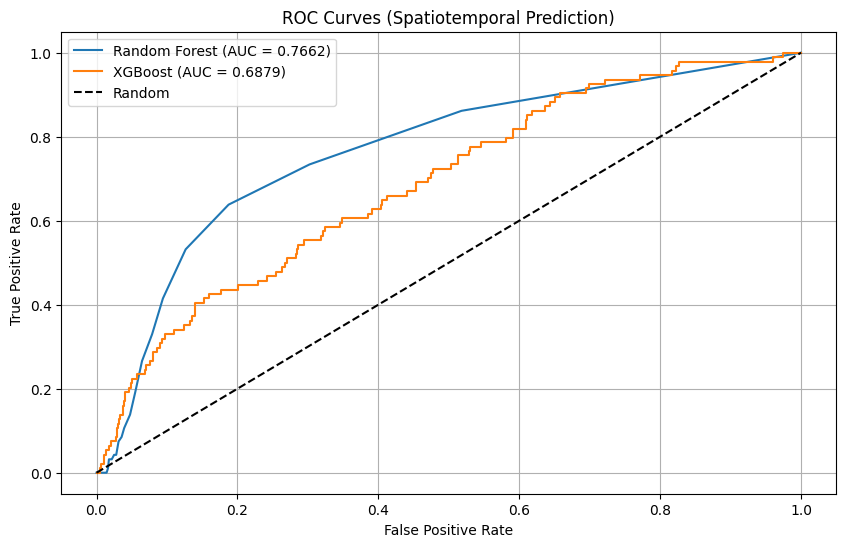

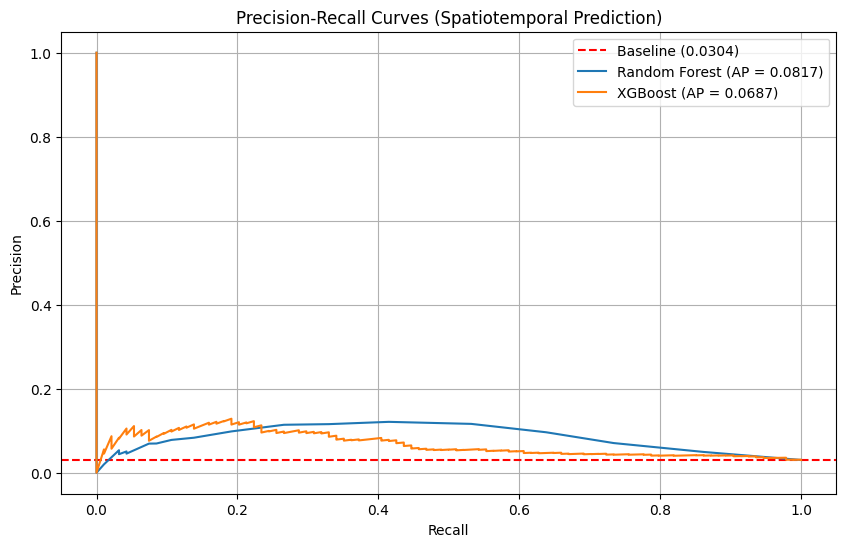

In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import shap
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score, classification_report

# Read the data with spatiotemporal target
df = pd.read_csv(r"C:\Users\thoma\Documents\GitHub\USGS\earthquake_data_with_spatiotemporal_target.csv")
df['datetime'] = pd.to_datetime(df['datetime'])

# Prepare features
exclude_cols = ['datetime', 'location', 'large_eq_next_30d_100km', 'place', 'title', 'magType', 
                'net', 'code', 'ids', 'sources', 'types', 'status', 'alert']

# Get numeric columns only
numeric_cols = df.select_dtypes(include=[np.number]).columns
feature_cols = [col for col in numeric_cols if col not in exclude_cols]

print("Selected features:", len(feature_cols))
print("First few features:", feature_cols[:5])

X = df[feature_cols]
y = df['large_eq_next_30d_100km']  # Using our new spatiotemporal target

# Handle non-numeric values
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.mean())

# Split the data chronologically
train_size = 0.8
split_idx = int(len(df) * train_size)
X_train = X.iloc[:split_idx]
X_test = X.iloc[split_idx:]
y_train = y.iloc[:split_idx]
y_test = y.iloc[split_idx:]

print(f"\nDataset Statistics:")
print(f"Training set size: {len(X_train):,}")
print(f"Test set size: {len(X_test):,}")
print(f"Positive class ratio in train: {y_train.mean():.4f}")
print(f"Positive class ratio in test: {y_test.mean():.4f}")

# Scale features
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=feature_cols)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=feature_cols)

# Train Random Forest with class weights
print("\nTraining Random Forest...")
pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
rf_model = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42
)
rf_model.fit(X_train_scaled, y_train)

# Train XGBoost with scale_pos_weight
print("\nTraining XGBoost...")
xgb_model = XGBClassifier(
    n_estimators=100,
    scale_pos_weight=pos_weight,
    random_state=42
)
xgb_model.fit(X_train_scaled, y_train)

# Get predictions and probabilities
rf_pred = rf_model.predict(X_test_scaled)
rf_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

xgb_pred = xgb_model.predict(X_test_scaled)
xgb_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]

# Calculate and display metrics
print("\nModel Performance Metrics:")
print("\nRandom Forest:")
print(classification_report(y_test, rf_pred))
print(f"ROC-AUC Score: {roc_auc_score(y_test, rf_proba):.4f}")
print(f"Average Precision Score: {average_precision_score(y_test, rf_proba):.4f}")

print("\nXGBoost:")
print(classification_report(y_test, xgb_pred))
print(f"ROC-AUC Score: {roc_auc_score(y_test, xgb_proba):.4f}")
print(f"Average Precision Score: {average_precision_score(y_test, xgb_proba):.4f}")

# Plot ROC curves
plt.figure(figsize=(10, 6))
for model_name, y_pred_proba in [('Random Forest', rf_proba), ('XGBoost', xgb_proba)]:
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.4f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (Spatiotemporal Prediction)')
plt.legend()
plt.grid(True)
plt.show()

# Plot Precision-Recall curves
plt.figure(figsize=(10, 6))
baseline = y_test.mean()
plt.axhline(y=baseline, color='r', linestyle='--', label=f'Baseline ({baseline:.4f})')

for model_name, y_pred_proba in [('Random Forest', rf_proba), ('XGBoost', xgb_proba)]:
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    ap_score = average_precision_score(y_test, y_pred_proba)
    plt.plot(recall, precision, label=f'{model_name} (AP = {ap_score:.4f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves (Spatiotemporal Prediction)')
plt.legend()
plt.grid(True)
plt.show()